In [ ]:

import numpy as np
import pandas as pd
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os

# Suppress warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.get_logger().setLevel('ERROR')

from tensorflow.keras.models import Model
from tensorflow.keras.layers import (LSTM, Dense, Dropout, TextVectorization,
                                   Embedding, Bidirectional, BatchNormalization,
                                   Input, MultiHeadAttention, LayerNormalization,
                                   GlobalAveragePooling1D, GlobalMaxPooling1D,
                                   Concatenate)
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

print(" Libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")

✅ Libraries imported successfully!
TensorFlow version: 2.18.0


Self Attention Layer

In [ ]:
class SelfAttention(tf.keras.layers.Layer):
    def __init__(self, attention_dim=64, return_attention=False, **kwargs):
        self.attention_dim = attention_dim
        self.return_attention = return_attention
        super(SelfAttention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight",
                               shape=(input_shape[-1], self.attention_dim),
                               initializer="glorot_uniform",
                               trainable=True)
        self.b = self.add_weight(name="att_bias",
                               shape=(self.attention_dim,),
                               initializer="zeros",
                               trainable=True)
        self.u = self.add_weight(name="att_u",
                               shape=(self.attention_dim, 1),
                               initializer="glorot_uniform",
                               trainable=True)
        super(SelfAttention, self).build(input_shape)

    def call(self, inputs):
        # inputs shape: (batch_size, seq_len, embedding_dim)
        uit = K.tanh(K.dot(inputs, self.W) + self.b)
        ait = K.dot(uit, self.u)
        ait = K.squeeze(ait, -1)
        ait = K.softmax(ait)  # Using softmax directly

        # Compute weighted sum
        weighted_input = inputs * K.expand_dims(ait)
        output = K.sum(weighted_input, axis=1)

        if self.return_attention:
            return output, ait
        return output

Transformer Encoder

In [ ]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.1):
    # Multi-Head Attention
    attention_output = MultiHeadAttention(
        num_heads=num_heads, key_dim=head_size, dropout=dropout
    )(inputs, inputs)

    # Add & Norm
    attention_output = LayerNormalization(epsilon=1e-6)(inputs + attention_output)

    # Feed Forward
    ff_output = Dense(ff_dim, activation="relu")(attention_output)
    ff_output = Dense(inputs.shape[-1])(ff_output)
    ff_output = Dropout(dropout)(ff_output)

    # Add & Norm
    return LayerNormalization(epsilon=1e-6)(attention_output + ff_output)

Load Dataset

In [ ]:
print(" Loading datasets...")
try:
    train_df = pd.read_csv("/kaggle/input/1lstm-self-attention-mechanism/train.csv")
    val_df = pd.read_csv("/kaggle/input/1lstm-self-attention-mechanism/validation.csv")
    test_df = pd.read_csv("/kaggle/input/1lstm-self-attention-mechanism/test.csv")
    print(" Datasets loaded successfully!")
except Exception as e:
    print(f" Error loading datasets: {e}")

    print("Creating sample data for testing...")


print(" Dataset Shapes:")
print(f"Train: {train_df.shape}, Val: {val_df.shape}, Test: {test_df.shape}")

 Loading datasets...
 Datasets loaded successfully!
 Dataset Shapes:
Train: (10106, 2), Val: (1444, 2), Test: (2888, 2)


Data Preparation

In [ ]:

X_train = train_df['cleaned_text'].fillna('').astype(str).values
y_train = train_df.iloc[:, -1].values

X_val = val_df['cleaned_text'].fillna('').astype(str).values
y_val = val_df.iloc[:, -1].values

X_test = test_df['cleaned_text'].fillna('').astype(str).values
y_test = test_df.iloc[:, -1].values

# Analyze class distribution
print("\n" + "="*60)
print(" CLASS DISTRIBUTION ANALYSIS")
print("="*60)

for name, X, y in [("Train", X_train, y_train), ("Validation", X_val, y_val), ("Test", X_test, y_test)]:
    unique, counts = np.unique(y, return_counts=True)
    print(f"\n{name} Set ({len(y)} samples):")
    for cls, count in zip(unique, counts):
        percentage = (count / len(y)) * 100
        print(f"   {cls}: {count} samples ({percentage:.1f}%)")


 CLASS DISTRIBUTION ANALYSIS

Train Set (10106 samples):
   negative: 855 samples (8.5%)
   neutral: 5561 samples (55.0%)
   positive: 3690 samples (36.5%)

Validation Set (1444 samples):
   negative: 122 samples (8.4%)
   neutral: 795 samples (55.1%)
   positive: 527 samples (36.5%)

Test Set (2888 samples):
   negative: 245 samples (8.5%)
   neutral: 1589 samples (55.0%)
   positive: 1054 samples (36.5%)


Text vectorization

In [ ]:
MAX_TOKENS = 20000  # Reduced for stability
SEQUENCE_LENGTH = 150  # Reduced for stability
EMBEDDING_DIM = 100  # Reduced for stability

print(f"\n Text Vectorization Parameters:")
print(f"   Max Tokens: {MAX_TOKENS}")
print(f"   Sequence Length: {SEQUENCE_LENGTH}")
print(f"   Embedding Dim: {EMBEDDING_DIM}")

text_vectorization = TextVectorization(
    max_tokens=MAX_TOKENS,
    output_mode='int',
    output_sequence_length=SEQUENCE_LENGTH,
    standardize='lower_and_strip_punctuation',
    split='whitespace'
)

# Adapt on training data only
text_vectorization.adapt(X_train)
vocab_size = len(text_vectorization.get_vocabulary())
print(f"   Vocabulary size: {vocab_size}")


 Text Vectorization Parameters:
   Max Tokens: 20000
   Sequence Length: 150
   Embedding Dim: 100
   Vocabulary size: 1051


LABEL ENCODING + CLASS WEIGHTS

In [ ]:

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

num_classes = len(label_encoder.classes_)
print(f"\n Number of classes: {num_classes}")
print(f"   Classes: {list(label_encoder.classes_)}")

# Calculate class weights
try:
    class_weights = compute_class_weight(
        'balanced',
        classes=np.unique(y_train_encoded),
        y=y_train_encoded
    )
    class_weight_dict = dict(enumerate(class_weights))
    print(f"   Class weights: {class_weight_dict}")
except:
    class_weight_dict = None
    print("   Using uniform class weights")

# Convert to categorical
y_train_cat = to_categorical(y_train_encoded, num_classes)
y_val_cat = to_categorical(y_val_encoded, num_classes)
y_test_cat = to_categorical(y_test_encoded, num_classes)


 Number of classes: 3
   Classes: ['negative', 'neutral', 'positive']
   Class weights: {0: 3.9399610136452243, 1: 0.6057663489780015, 2: 0.9129177958446251}


SIMPLIFIED LSTM + SELF-ATTENTION MODEL

In [ ]:
print("\n" + "="*60)
print(" BUILDING SIMPLIFIED LSTM + SELF-ATTENTION MODEL")
print("="*60)

def create_simplified_lstm_attention_model():
    # Input layer
    inputs = Input(shape=(1,), dtype=tf.string, name="text_input")

    # Text vectorization
    vectorized = text_vectorization(inputs)

    # Embedding layer
    embedding = Embedding(
        input_dim=MAX_TOKENS + 1,
        output_dim=EMBEDDING_DIM,
        input_length=SEQUENCE_LENGTH,
        mask_zero=True,
        name="embedding_layer"
    )(vectorized)

    # Bidirectional LSTM 1
    lstm1 = Bidirectional(LSTM(64, return_sequences=True, dropout=0.2,
                              recurrent_dropout=0.1),
                         name="bilstm_1")(embedding)
    lstm1 = BatchNormalization(name="bn_1")(lstm1)

    # Bidirectional LSTM 2
    lstm2 = Bidirectional(LSTM(32, return_sequences=True, dropout=0.2,
                              recurrent_dropout=0.1),
                         name="bilstm_2")(lstm1)
    lstm2 = BatchNormalization(name="bn_2")(lstm2)

    # Self-Attention Mechanism
    attention_output, attention_weights = SelfAttention(
        attention_dim=32, return_attention=True, name="self_attention"
    )(lstm2)

    # Alternative: Use Global Pooling instead of Transformer for stability
    avg_pool = GlobalAveragePooling1D()(lstm2)
    max_pool = GlobalMaxPooling1D()(lstm2)

    # Concatenate features
    concatenated = Concatenate()([
        attention_output,
        avg_pool,
        max_pool
    ])

    # Dense layers
    dense1 = Dense(64, activation='relu', name="dense_1")(concatenated)
    dense1 = BatchNormalization(name="bn_3")(dense1)
    dense1 = Dropout(0.3, name="dropout_1")(dense1)

    dense2 = Dense(32, activation='relu', name="dense_2")(dense1)
    dense2 = BatchNormalization(name="bn_4")(dense2)
    dense2 = Dropout(0.2, name="dropout_2")(dense2)

    # Output layer
    outputs = Dense(num_classes, activation='softmax', name="output_layer")(dense2)

    # Create model
    model = Model(inputs=inputs, outputs=outputs, name="lstm_attention_model")

    return model, attention_weights

# Create model
try:
    model, attention_weights = create_simplified_lstm_attention_model()
    print(" Model created successfully!")
except Exception as e:
    print(f" Error creating model: {e}")
    # Fallback to simple model
    print("Creating simple fallback model...")
    model = tf.keras.Sequential([
        text_vectorization,
        Embedding(MAX_TOKENS + 1, EMBEDDING_DIM),
        Bidirectional(LSTM(64)),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    attention_weights = None

# Custom optimizer
optimizer = Adam(learning_rate=0.001)

# Compile model
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\n Model Architecture:")
try:
    model.summary()
except:
    print("Model summary not available")


 BUILDING SIMPLIFIED LSTM + SELF-ATTENTION MODEL
 Model created successfully!

 Model Architecture:


Model: "lstm_attention_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_vectorization… │ (None, 150)       │          0 │ text_input[0][0]  │
│ (TextVectorization) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_layer     │ (None, 150, 100)  │  2,000,100 │ text_vectorizati… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_3         │ (None, 150)       │          0 │ text_vectorizati… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bilstm_1            │ (None, 150, 128)  │     84,480 │ embedding_layer[… │
│ (Bidirectional)     │                   │            │ not_equal_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_1                │ (None, 150, 128)  │        512 │ bilstm_1[0][0],   │
│ (BatchNormalizatio… │                   │            │ not_equal_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bilstm_2            │ (None, 150, 64)   │     41,216 │ bn_1[0][0],       │
│ (Bidirectional)     │                   │            │ not_equal_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_2                │ (None, 150, 64)   │        256 │ bilstm_2[0][0],   │
│ (BatchNormalizatio… │                   │            │ not_equal_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ self_attention      │ [(None, 64),      │      2,112 │ bn_2[0][0]        │
│ (SelfAttention)     │ (None, 150)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ bn_2[0][0],       │
│ (GlobalAveragePool… │                   │            │ not_equal_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 64)        │          0 │ bn_2[0][0]        │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 192)       │          0 │ self_attention[0… │
│ (Concatenate)       │                   │            │ global_average_p… │
│                     │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │     12,352 │ concatenate_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_3                │ (None, 64)        │        256 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ bn_3[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │      2,080 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_4                │ (None, 32)        │        128 │ dense_2[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 2,143,591 (8.18 MB)

 Trainable params: 2,143,015 (8.17 MB)

 Non-trainable params: 576 (2.25 KB)

 CALLBACKS

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True,
    mode='max',
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    'best_lstm_attention_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

callbacks_list = [early_stopping, reduce_lr, model_checkpoint]


MODEL TRAINING

In [ ]:
print("\n" + "="*60)
print(" STARTING MODEL TRAINING")
print("="*60)

print(f" Training samples: {len(X_train)}")
print(f" Validation samples: {len(X_val)}")
print(f" Batch size: 32")
print(f" Max epochs: 30")

try:
    # Train the model
    history = model.fit(
        X_train, y_train_cat,
        epochs=30,
        batch_size=32,
        validation_data=(X_val, y_val_cat),
        class_weight=class_weight_dict,
        callbacks=callbacks_list,
        verbose=1,
        shuffle=True
    )
    print("\n Training completed successfully!")

except Exception as e:
    print(f" Training error: {e}")
    print("Trying with smaller batch size...")
    history = model.fit(
        X_train, y_train_cat,
        epochs=20,
        batch_size=16,
        validation_data=(X_val, y_val_cat),
        verbose=1,
        shuffle=True
    )


 STARTING MODEL TRAINING
 Training samples: 10106
 Validation samples: 1444
 Batch size: 32
 Max epochs: 30
Epoch 1/30
316/316 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - accuracy: 0.3773 - loss: 1.2821
Epoch 1: val_accuracy improved from -inf to 0.65651, saving model to best_lstm_attention_model.h5


316/316 ━━━━━━━━━━━━━━━━━━━━ 161s 445ms/step - accuracy: 0.3775 - loss: 1.2816 - val_accuracy: 0.6565 - val_loss: 0.9709 - learning_rate: 0.0010
Epoch 2/30
316/316 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step - accuracy: 0.5903 - loss: 0.7074
Epoch 2: val_accuracy improved from 0.65651 to 0.75000, saving model to best_lstm_attention_model.h5


316/316 ━━━━━━━━━━━━━━━━━━━━ 142s 451ms/step - accuracy: 0.5905 - loss: 0.7072 - val_accuracy: 0.7500 - val_loss: 0.5688 - learning_rate: 0.0010
Epoch 3/30
316/316 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - accuracy: 0.7691 - loss: 0.4596
Epoch 3: val_accuracy improved from 0.75000 to 0.82271, saving model to best_lstm_attention_model.h5


316/316 ━━━━━━━━━━━━━━━━━━━━ 143s 453ms/step - accuracy: 0.7692 - loss: 0.4595 - val_accuracy: 0.8227 - val_loss: 0.4179 - learning_rate: 0.0010
Epoch 4/30
316/316 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.8336 - loss: 0.3363
Epoch 4: val_accuracy improved from 0.82271 to 0.84280, saving model to best_lstm_attention_model.h5


316/316 ━━━━━━━━━━━━━━━━━━━━ 142s 450ms/step - accuracy: 0.8336 - loss: 0.3363 - val_accuracy: 0.8428 - val_loss: 0.3721 - learning_rate: 0.0010
Epoch 5/30
316/316 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - accuracy: 0.8717 - loss: 0.2727
Epoch 5: val_accuracy improved from 0.84280 to 0.85803, saving model to best_lstm_attention_model.h5


316/316 ━━━━━━━━━━━━━━━━━━━━ 140s 445ms/step - accuracy: 0.8717 - loss: 0.2727 - val_accuracy: 0.8580 - val_loss: 0.3438 - learning_rate: 0.0010
Epoch 6/30
316/316 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - accuracy: 0.8894 - loss: 0.2281
Epoch 6: val_accuracy did not improve from 0.85803
316/316 ━━━━━━━━━━━━━━━━━━━━ 140s 444ms/step - accuracy: 0.8894 - loss: 0.2282 - val_accuracy: 0.8331 - val_loss: 0.4701 - learning_rate: 0.0010
Epoch 7/30
316/316 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step - accuracy: 0.9083 - loss: 0.1965
Epoch 7: val_accuracy did not improve from 0.85803
316/316 ━━━━━━━━━━━━━━━━━━━━ 141s 446ms/step - accuracy: 0.9083 - loss: 0.1965 - val_accuracy: 0.8504 - val_loss: 0.4187 - learning_rate: 0.0010
Epoch 8/30
316/316 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - accuracy: 0.9117 - loss: 0.1927
Epoch 8: val_accuracy improved from 0.85803 to 0.88573, saving model to best_lstm_attention_model.h5


316/316 ━━━━━━━━━━━━━━━━━━━━ 141s 448ms/step - accuracy: 0.9117 - loss: 0.1927 - val_accuracy: 0.8857 - val_loss: 0.2873 - learning_rate: 0.0010
Epoch 9/30
316/316 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step - accuracy: 0.9209 - loss: 0.1682
Epoch 9: val_accuracy improved from 0.88573 to 0.89543, saving model to best_lstm_attention_model.h5


316/316 ━━━━━━━━━━━━━━━━━━━━ 141s 446ms/step - accuracy: 0.9209 - loss: 0.1682 - val_accuracy: 0.8954 - val_loss: 0.2788 - learning_rate: 0.0010
Epoch 10/30
316/316 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step - accuracy: 0.9367 - loss: 0.1514
Epoch 10: val_accuracy improved from 0.89543 to 0.91205, saving model to best_lstm_attention_model.h5


316/316 ━━━━━━━━━━━━━━━━━━━━ 141s 446ms/step - accuracy: 0.9367 - loss: 0.1514 - val_accuracy: 0.9120 - val_loss: 0.2267 - learning_rate: 0.0010
Epoch 11/30
316/316 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - accuracy: 0.9375 - loss: 0.1365
Epoch 11: val_accuracy did not improve from 0.91205
316/316 ━━━━━━━━━━━━━━━━━━━━ 140s 443ms/step - accuracy: 0.9375 - loss: 0.1366 - val_accuracy: 0.9086 - val_loss: 0.2523 - learning_rate: 0.0010
Epoch 12/30
316/316 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - accuracy: 0.9484 - loss: 0.1174
Epoch 12: val_accuracy did not improve from 0.91205
316/316 ━━━━━━━━━━━━━━━━━━━━ 140s 444ms/step - accuracy: 0.9484 - loss: 0.1175 - val_accuracy: 0.9030 - val_loss: 0.2762 - learning_rate: 0.0010
Epoch 13/30
316/316 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step - accuracy: 0.9515 - loss: 0.1124
Epoch 13: val_accuracy did not improve from 0.91205
316/316 ━━━━━━━━━━━━━━━━━━━━ 142s 445ms/step - accuracy: 0.9515 - loss: 0.1124 - val_accuracy: 0.9086 - val_loss: 0.2506 - learning_rate: 0.00

316/316 ━━━━━━━━━━━━━━━━━━━━ 140s 442ms/step - accuracy: 0.9557 - loss: 0.1063 - val_accuracy: 0.9148 - val_loss: 0.2571 - learning_rate: 0.0010
Epoch 16/30
316/316 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step - accuracy: 0.9608 - loss: 0.0920
Epoch 16: val_accuracy improved from 0.91482 to 0.91898, saving model to best_lstm_attention_model.h5


316/316 ━━━━━━━━━━━━━━━━━━━━ 141s 446ms/step - accuracy: 0.9608 - loss: 0.0920 - val_accuracy: 0.9190 - val_loss: 0.2465 - learning_rate: 5.0000e-04
Epoch 17/30
316/316 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step - accuracy: 0.9775 - loss: 0.0566
Epoch 17: val_accuracy did not improve from 0.91898
316/316 ━━━━━━━━━━━━━━━━━━━━ 140s 442ms/step - accuracy: 0.9775 - loss: 0.0566 - val_accuracy: 0.9183 - val_loss: 0.2745 - learning_rate: 5.0000e-04
Epoch 18/30
316/316 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step - accuracy: 0.9766 - loss: 0.0582
Epoch 18: val_accuracy did not improve from 0.91898
316/316 ━━━━━━━━━━━━━━━━━━━━ 141s 445ms/step - accuracy: 0.9766 - loss: 0.0582 - val_accuracy: 0.9051 - val_loss: 0.3000 - learning_rate: 5.0000e-04
Epoch 19/30
316/316 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - accuracy: 0.9777 - loss: 0.0516
Epoch 19: val_accuracy did not improve from 0.91898
316/316 ━━━━━━━━━━━━━━━━━━━━ 143s 452ms/step - accuracy: 0.9777 - loss: 0.0516 - val_accuracy: 0.9100 - val_loss: 0.2900 - learnin

 COMPREHENSIVE EVALUATION


 COMPREHENSIVE MODEL EVALUATION
 Loaded best model weights for evaluation

 Test Metrics:
   Accuracy:  0.9075
   Loss:      0.2956

 Generating predictions...

 CLASSIFICATION REPORT
              precision    recall  f1-score   support

    negative      0.721     0.853     0.781       245
     neutral      0.948     0.882     0.914      1589
    positive      0.903     0.959     0.930      1054

    accuracy                          0.908      2888
   macro avg      0.857     0.898     0.875      2888
weighted avg      0.912     0.908     0.908      2888


 CONFUSION MATRIX


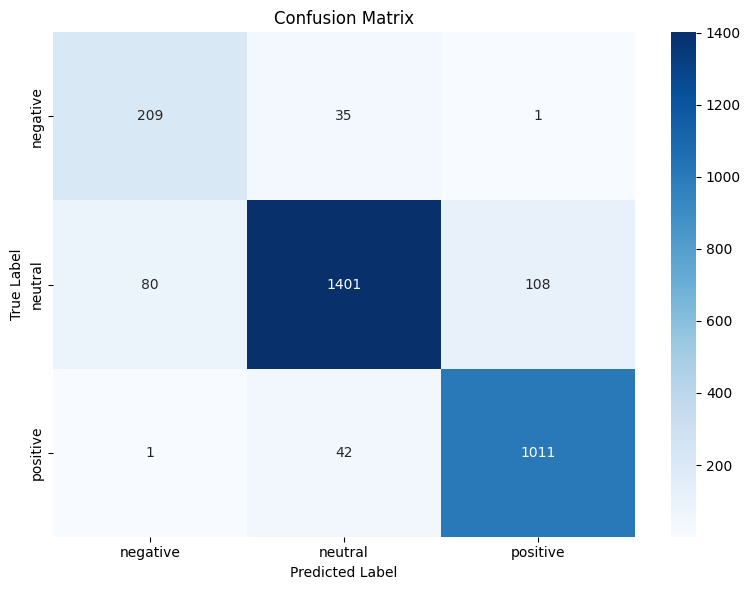

In [ ]:
print("\n" + "="*60)
print(" COMPREHENSIVE MODEL EVALUATION")
print("="*60)

# Load best model if available
try:
    model.load_weights('best_lstm_attention_model.h5')
    print(" Loaded best model weights for evaluation")
except:
    print(" Using final model weights for evaluation")

# Evaluate on test set
try:
    test_loss, test_acc = model.evaluate(X_test, y_test_cat, verbose=0, batch_size=32)
    print(f"\n Test Metrics:")
    print(f"   Accuracy:  {test_acc:.4f}")
    print(f"   Loss:      {test_loss:.4f}")
except Exception as e:
    print(f" Evaluation error: {e}")
    test_acc = 0.0

# Detailed predictions
print("\n Generating predictions...")
try:
    y_pred_probs = model.predict(X_test, verbose=0, batch_size=32)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = y_test_encoded

    # Classification Report
    print("\n" + "="*60)
    print(" CLASSIFICATION REPORT")
    print("="*60)
    print(classification_report(y_true, y_pred, target_names=label_encoder.classes_, digits=3))

    # Confusion Matrix
    print("\n CONFUSION MATRIX")
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f" Prediction error: {e}")


 TRAINING HISTORY VISUALIZATION


 TRAINING HISTORY


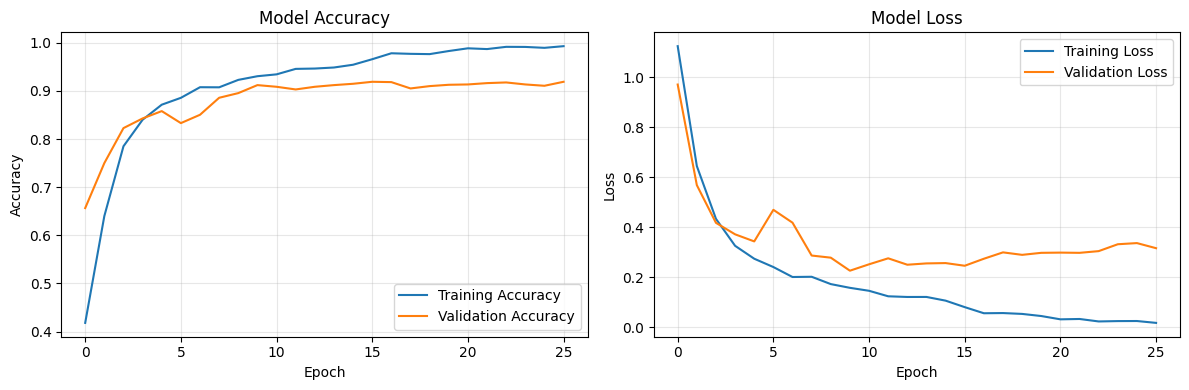

In [ ]:
print("\n" + "="*60)
print(" TRAINING HISTORY")
print("="*60)

try:
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f" Plotting error: {e}")


FINAL SUMMARY

In [ ]:
print("\n" + "="*60)
print(" FINAL SUMMARY")
print("="*60)

print(" LSTM + Self-Attention Model Completed!")
print(" Key Features:")
print("   - Bidirectional LSTM for context")
print("   - Self-Attention for important words")
print("   - Multiple feature pooling")
print("   - Early stopping to prevent overfitting")

if 'test_acc' in locals() and test_acc > 0:
    print(f" Final Test Accuracy: {test_acc:.4f}")

print("\n" + "="*60)
print(" MODEL PIPELINE COMPLETED!")
print("="*60)


 FINAL SUMMARY
 LSTM + Self-Attention Model Completed!
 Key Features:
   - Bidirectional LSTM for context
   - Self-Attention for important words
   - Multiple feature pooling
   - Early stopping to prevent overfitting
 Final Test Accuracy: 0.9075

 MODEL PIPELINE COMPLETED!
